In [1]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -q fastkaggle
from fastkaggle import *

# install required libraries


In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')
from fastai.vision.all import *
set_seed(42)

 I'm going to  resize all the images to half their height and width -- which reduces their number of pixels 4x. This should mean an around 4x increase in performance for training small models.

Luckily, fastai has a function which does exactly this, whilst maintaining the folder structure of the data: resize_images.

In [3]:
train_path = Path('resized')
resize_images(path/'train_images', dest=train_path, max_size = 256, recurse=True)

dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,items_tfms=Resize(192,256))


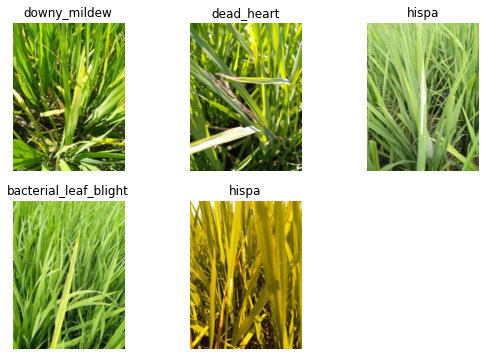

In [4]:
dls.show_batch(max_n=5) 

I,m going to try a  few different architectures and image processing approaches (item and batch transforms). In order to make this easier, i will make a  little function in which i  can pass the architecture, item transforms, and batch transforms to:

In [5]:

def train(arch, item,batch, epochs=5):
    dls = ImageDataLoaders.from_folder(train_path, seed=42, valid_pct=0.2, item_tfms=item, batch_tfms=batch)
    learn = vision_learner(dls,arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [6]:


learn = train('resnet26d', item=Resize(192),batch=aug_transforms(size=128,min_scale=0.75))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.894384,1.465243,0.448342,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.246341,0.995263,0.316194,00:32
1,1.009784,0.709289,0.229697,00:33
2,0.722875,0.512591,0.160980,00:32
3,0.507947,0.402096,0.125901,00:32
4,0.429895,0.387513,0.118693,00:33


As seen above, the training time is a lot faster this time , but the accuracy is still similar, so im going to try a different model, the Convnext model

In [7]:
arch = 'convnext_small_in22k'
learn = train(arch, item=Resize(192, method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.336190,0.803142,0.245074,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.665825,0.426180,0.136473,00:53
1,0.498799,0.324984,0.096108,00:53
2,0.335909,0.232048,0.074003,00:52
3,0.190039,0.170445,0.055262,00:53
4,0.115096,0.151587,0.048534,00:53


 error rate is down to an impressive 4% from 11.3%

lets try using padding instead of the squish method

In [8]:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(192, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))


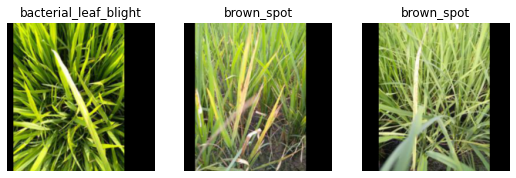

In [9]:
dls.show_batch(max_n=3)

In [10]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.299499,0.858277,0.267179,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.642396,0.425779,0.134551,00:59
1,0.493286,0.416389,0.117251,00:59
2,0.330718,0.223859,0.068236,00:59
3,0.207007,0.157689,0.049976,01:00
4,0.137279,0.141905,0.041807,01:00
